# Homework 2

В Homework 1 мы научились находить оптимальную политику для агента в средах диниамика которых нам известна. Теперь попробуем найти оптимальные действия для агента в среде без известной динамики и реализуем 2 базовых алгоритма - Q-learning и REIFORCE (самостоятельно). Реализуем алгоритмы сразу с использованием нелинейного аппроксиматора Q-функции (DQN) и политики (REINFORCE) - нейронной сети.

#### Для работы нам потребуется установить gym и numpy. Gym следует установить командой pip install gym=0.9.2. Также необходимо установить фреймворк для автоматического дифференцирования <a href=https://pytorch.org/get-started/locally/>PyTorch</a> для вашей операционной системы.
#### Весь код предназначен для запуска на CPU - внесите необходмые изменения для запуска на GPU.

In [12]:
# Импортируем необходимые библиотеки
import gym
import random
import math
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython.display import Image
%matplotlib inline

Агент будет действовать в среде <a href=https://gym.openai.com/envs/CartPole-v0>CartPole-v0</a>. В этой среде агент должен удержать шест, который закреплен на тележке, в вертикальном положении. Агент может прикладывать силу *+1* или *-1* к тележке в попытке удержать шест. Эпизод игры заканчивается, если шест отклоняется от вертикального положения больше, чем на *15* градусов или тележка сдвигается больше, чем на *2.4* единицы расстояния от центра. За каждый шаг времени, когда шест находится в вертикальном положении, агент получает награду в размере *+1* очко. Задаче считается "решенной" при получении агентом средней за 100 попыток награды *195* очков.

## DQN

Создадим уже привычным способом среду

In [13]:
env = gym.make('CartPole-v0')

Как мы знаем из лекций, для реализации алгоритма DQN нам потребуется несколько вспомогательных вещей, а именно - Replay Buffer для сохранения переходов вида (state, action, reward, next_state, флаг done) - он нам понадобится для обучения нашей нейронной сети, а также саму нейронную сеть.

Начнем с нейронной сети. Сеть должна принимать на вход вектор, описывающий текущее состояние (в нашем случае размерности 4), а на выходе выдвать значение Q-функции для каждого действия. При выборе действий агентом мы будем использовать $\epsilon$-greedy политику.

In [14]:
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n

In [15]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(num_actions)
        return action

Напишем Replay Buffer.

In [16]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        # используем функцию deque из библиотеки collections для создания очереди.
        self.buffer = deque(maxlen=capacity)
    
    # функция, сохраняющая переходы в Replay Buffer
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))
    
    # функция, реализующая семплирование переходов из Replay Buffer-а для обучение агента
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

Теперь нам необходимо реализовать вспомогательную функцию для непосредственной тренировки агента.

#### На основе материала лекций вам необходимо на основе батча, полученного из Replay Buffer-a, релизовать шаг обновления параметров сети - рассчитать необходимые значения Q-функции для соответствующих шагов, а также функцию потерь для обновления. Следует обратить внимание на следующие моменты:
* какие значение Q-функции использовать для сооветвующих компонентов обновления Беллмана;
* что делать, если в переходе флаг done принимает значение True
* какие значения Q-функции мы используем для расчета градиентов, а какие - нет

In [17]:
def train(batch_size, gamma):
    
    # сэмплируем из Replay Buffer-a батч переходов
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # преобразуем компоненты батча в тензоры PyTorch
    state = torch.tensor(state, dtype=torch.float32)
    next_state = torch.tensor(next_state, dtype=torch.float32)
    action = torch.tensor(action, dtype=torch.int64)
    reward = torch.tensor(reward, dtype=torch.float32)
    done = torch.tensor(done, dtype=torch.float32)
    
    # YOUR CODE GOES HERE
    q_val2 = model(next_state)
    q_val2 = q_val2.max(1)[0]
    
    q_val = model(state)
    q_val = q_val.gather(1, action.unsqueeze(1)).squeeze(1)
    

    q_exp = reward + gamma * q_val2 * (1 - done)

    loss = (q_val - q_exp.detach()).pow(2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

Также, нам нужна вспомогательная функция, которая поможет визуализировать наши rewards и значения функции потерь.

In [18]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('step %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

В заключение, для стабилизации обучения нам нужна функция, которая постепенно уменьшает $\epsilon$ для $\epsilon$-greedy политики. Это позволит нам регулировать баланс Exploration и Exploitation во времени и стабилизировать сходимость политики агента.

In [19]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_decay_by_step = lambda step: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * step / epsilon_decay)

Теперь мы можем создать все необходимые объекты для обучения агента - нейронную сеть, оптимизатор, Replay Buffer.

In [20]:
model = DQN(num_inputs, num_actions)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

Также зададим гиперпараметры алгоритма - количество шагов, размер батча и фактор дисконтирования.

In [21]:
steps = 10000
batch_size = 32
gamma = 0.99

Реализуем основной цикл обучения. Наш алгоритм должен довольно быстрой сойтись к значению reward равному 200.

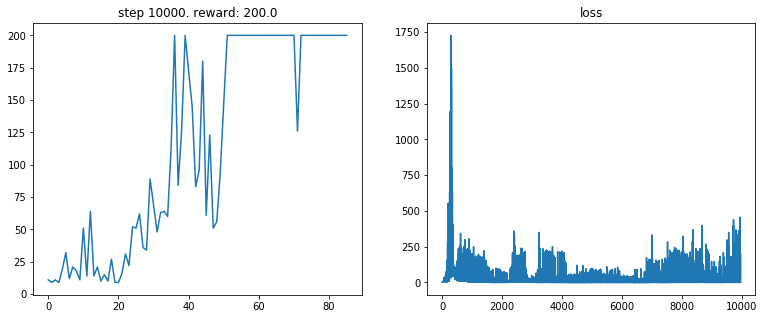

In [22]:
losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for step in range(1, steps + 1):
    epsilon = epsilon_decay_by_step(step)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = train(batch_size, gamma)
        losses.append(loss.item())
        
    if step % 200 == 0:
        plot(step, all_rewards, losses)

## Дополнительное задание

Релизуйте алгоритм REINFORCE в той же среде Cartpole-v0 (для вдохновения можно использовать реализацию из туториала PyToch)